# 프로젝트 : OCR
2024-07-09
<br>이경규

### 데이터 : MJSynth
### 모델 : RCNN
### 목표
: OCR의 RCNN모델을 직접 설계하여 추론과정을 수행

#### 1. Detection - keras.ocr Detector
#### 2. Recognition- RCNN
#### 3. Inference- sample data

## 0. 라이브러리

In [1]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr

import re
import six
import math
import lmdb
import os

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8


## 1. Detection
### 1.1 샘플 데이터 로드    

In [20]:
# BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

### 1.2 텍스트 탐지
- `keras_ocr.detection` 의 `Detector`사용
    - result_img : 텍스트 검출 영역을 표시한 이미지
    - cropped_imgs : 검출된 텍스트 영역의 이미지 리스트
- `detect_text()`
    - 이미지 로드 및 전처리
        - **result_img** : 이미지를 로드하고 RGB형식으로 변환
        - **img** : 이미지를 NumPy 배열로 변환
    - 차원 확장 및 차원 순서 변경
        - **img_expanded** : (1, height, width, channels)의 형태로 배치차원 추가
            - 검출 모델에서 배치 형태의 입력을 사용
    - 텍스트 검출 수행
        - **ocr_result** : 텍스트 영역의 좌표 텍스트 검출
    - Bounding Box 그리기 및 텍스트 영역 잘라내기
        - **ImageDraw.Draw(result_img)** : 이미지 수정을 위한 그리기 객체
        - **word_box**로 텍스트 영역을 잘라내고 `cropped_imgs`에 저장

In [3]:
from keras_ocr.detection import Detector
from PIL import Image, ImageDraw
detector = Detector()

def detect_text(img_path):
    
    # 이미지 로드 및 전처리
    result_img = Image.open(img_path).convert('RGB')
    img = np.array(result_img) # 
    
    # 차원 확장 및 순서 변경
    img_expanded = np.expand_dims(img, axis=0)
    
    # 텍스트 검출 수행
    ocr_result = detector.detect(images=img_expanded)[0]
    
    # Bounding Box 그리기 및 텍스트 영역 잘라내기
    img_draw = ImageDraw.Draw(result_img)
    
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(result_img.crop(word_box))
        
    return result_img, cropped_imgs

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


### 1.3 detection 결과 확인

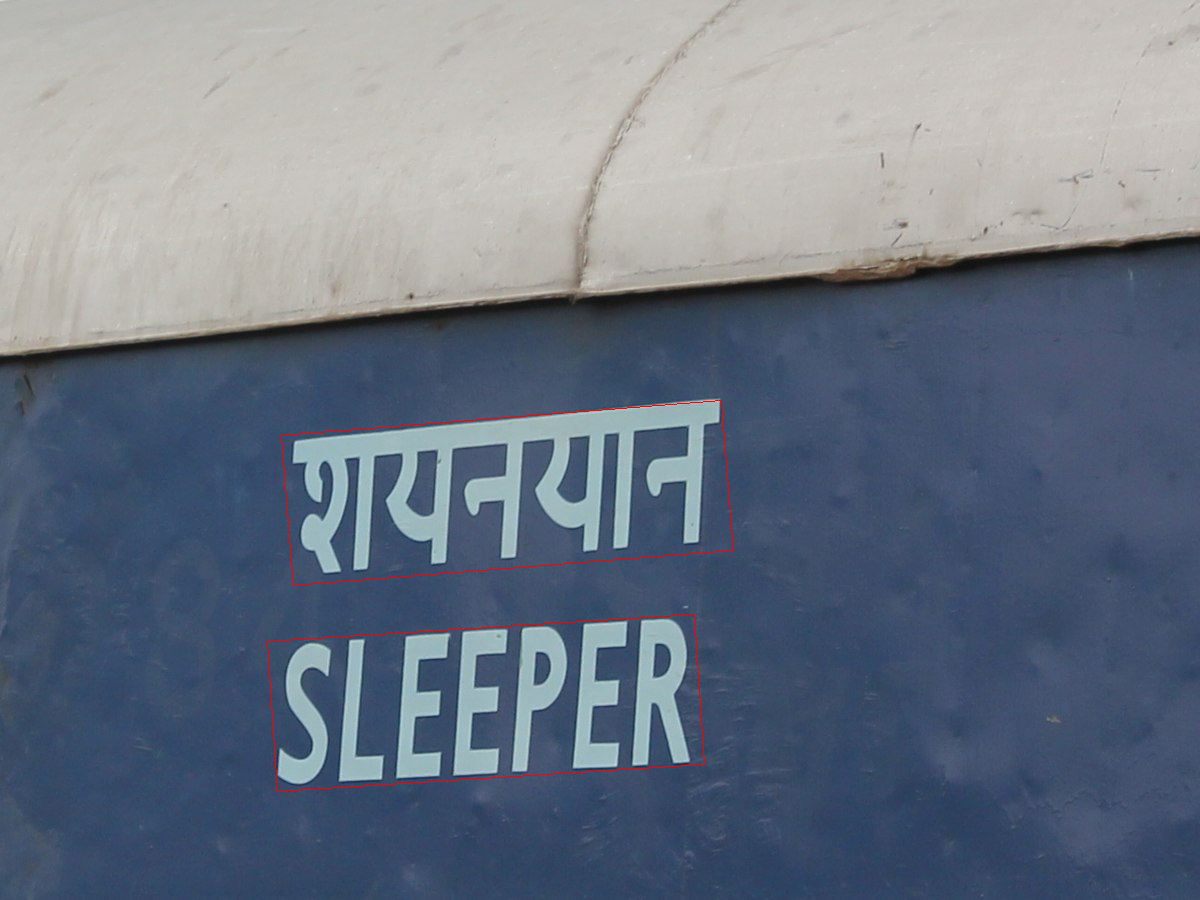

In [21]:
from PIL import Image, ImageDraw
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

## 2. CTC
### 2.1 라벨 인코딩

In [5]:
class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [6]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

label_converter = LabelConverter(TARGET_CHARACTERS)

The total number of characters is 36


### 2.2 CTC loss
- CTC loss를 계산하기 위한 Lambda 함수
    - Keras의 `keras.ctc_batch_cost()`를 사용하여 loss 계산

In [7]:
def ctc_lambda_func(args):
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

## 3. Recognition
### 3.1 CRNN 모델 정의
- CNN : 이미지의 특성 추출 (특성 맵)
- RNN : 시퀀스로 변환하여 각 스탭의 문자 확률 계산
- CTC Loss : 문자 인식

In [8]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # CNN
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    
    # RNN
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)
    
    # CTC Loss
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

### 3.2 가중치 로드

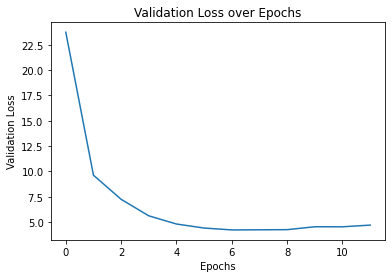

In [9]:
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

model = build_crnn_model()
model.load_weights(checkpoint_path)

import pickle
import matplotlib.pyplot as plt
with open('/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest4/model/training_history.pkl', 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['val_loss'])
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

### 3.3 Inference 모델
- `model_pred`
- crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없음
- crnn 모델의 입력중 'input_image' 부분만 사용한 모델 생성

In [10]:
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

## 4. Inference

In [11]:
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = tf.keras.backend.get_value(
        tf.keras.backend.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

def recognize_img(pil_img, input_img_size=(100, 32)):
    # 이미지 전처리
    img_array = np.array(pil_img.resize(input_img_size)).transpose(1, 0, 2)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # 모델 예측
    y_pred = model_pred.predict(img_array)

    # CTC 디코딩
    result = decode_predict_ctc(y_pred, chars="-" + TARGET_CHARACTERS)[0].replace('-', '')
    return result

In [12]:
for _img in cropped_img:
    result = recognize_img(_img)

In [25]:
print(result)
display(cropped_img[1])

CIENS9999999999999999999


## 5. More

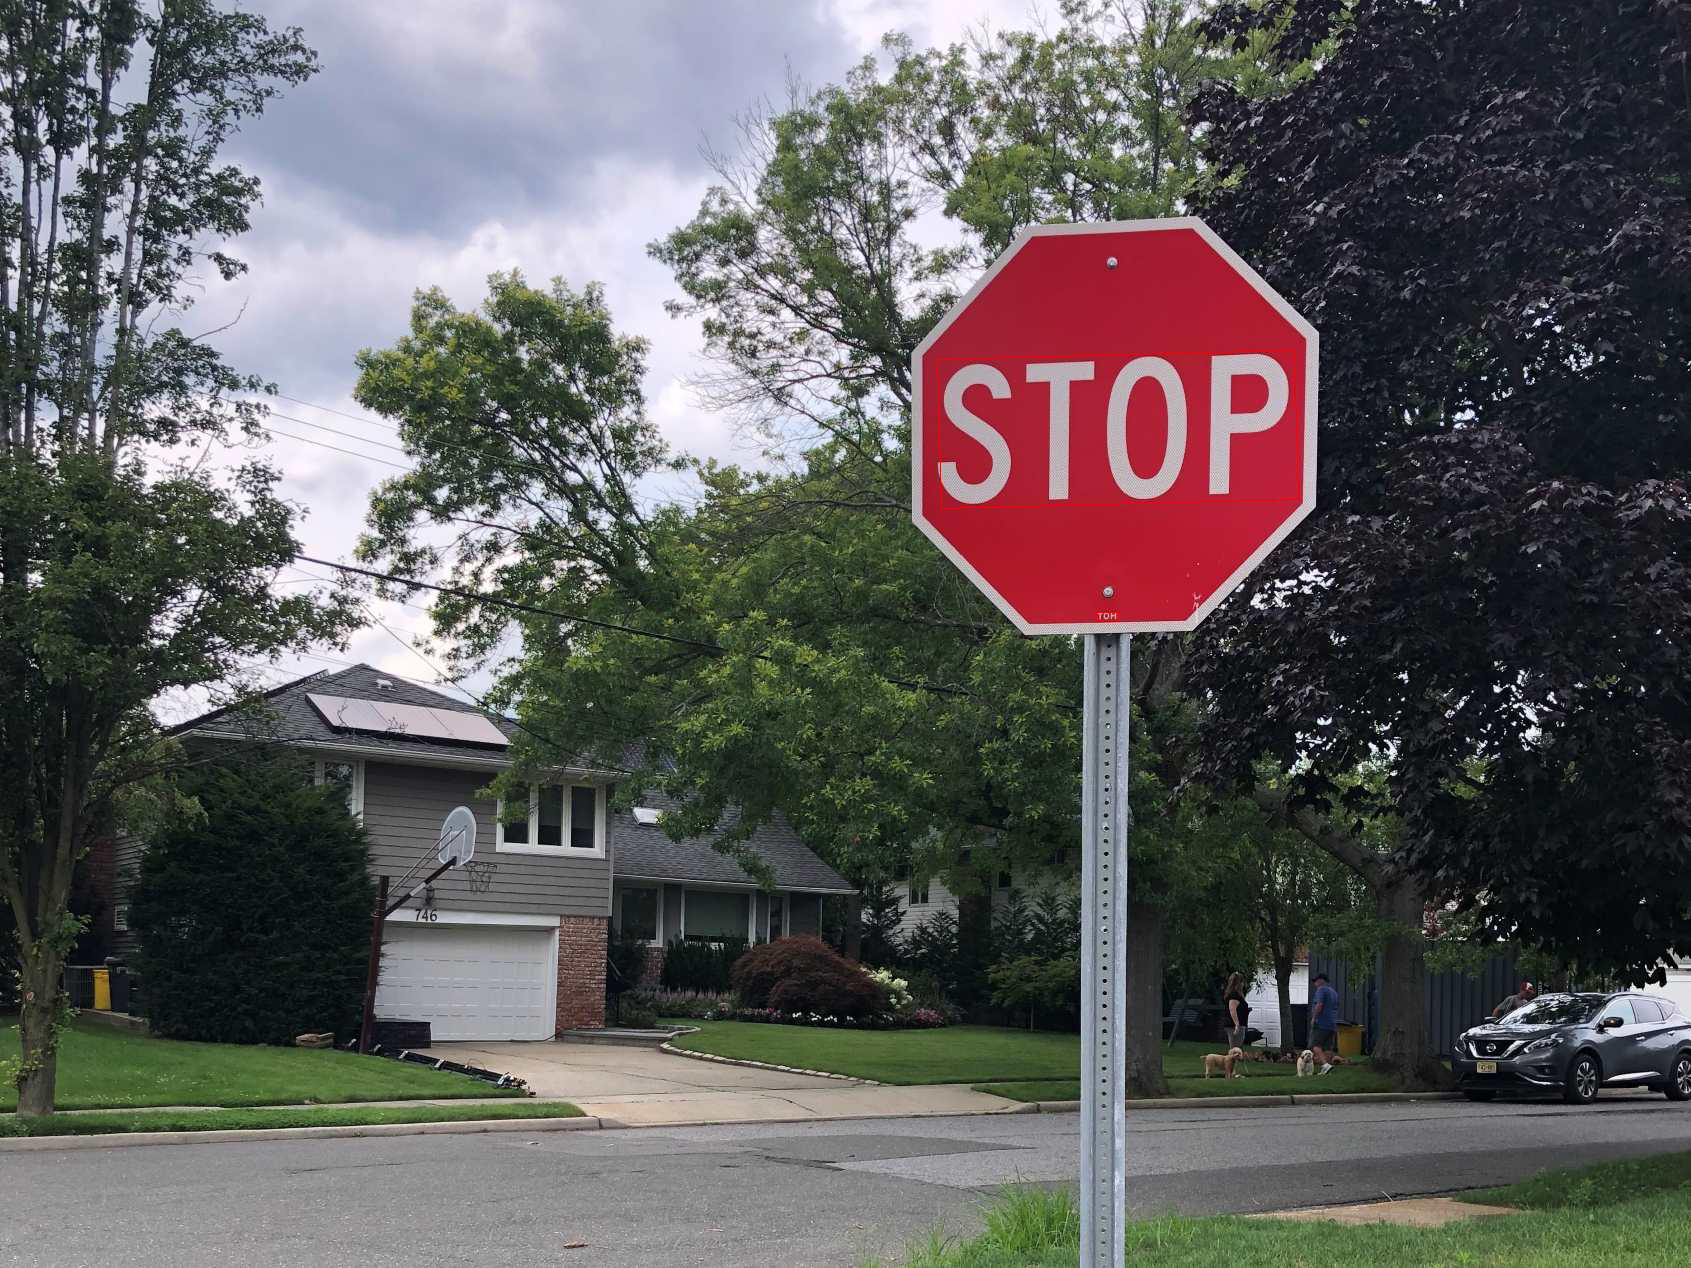

CIENS9999999999999999999


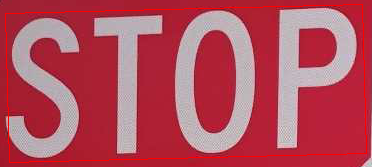

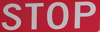

In [24]:
SAMPLE_IMG_PATH = '/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest4/engstop.jpg'
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)
for _img in cropped_img:
    result = recognize_img(_img)
print(result)

display(cropped_img[0])
img=cropped_img[0]
img_array = np.array(img)
new_size = (100, 32)
resized_img = Image.fromarray(img_array).resize(new_size)
resized_img_array = np.array(resized_img)
resized_img.show()

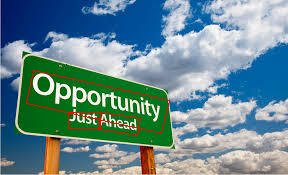

SANEALS99999999999999999


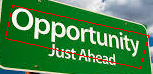

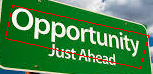

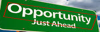

In [26]:
SAMPLE_IMG_PATH = '/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest4/engsign.jpg'
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)
for _img in cropped_img:
    result = recognize_img(_img)
print(result)
display(cropped_img[0])

display(cropped_img[0])
img=cropped_img[0]
img_array = np.array(img)
new_size = (100, 32)
resized_img = Image.fromarray(img_array).resize(new_size)
resized_img_array = np.array(resized_img)
resized_img.show()

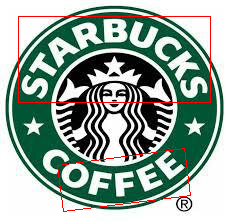

OABESD99999999999999999


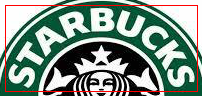

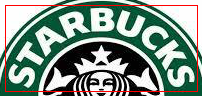

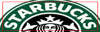

In [27]:
SAMPLE_IMG_PATH = '/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest4/starbucks.jpg'
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)
for _img in cropped_img:
    result = recognize_img(_img)
print(result)
display(cropped_img[0])

display(cropped_img[0])
img=cropped_img[0]
img_array = np.array(img)
new_size = (100, 32)
resized_img = Image.fromarray(img_array).resize(new_size)
resized_img_array = np.array(resized_img)
resized_img.show()

### 회고
- 배운점: OCR의 구조와 각 detection, recognition 방법에 대해 학습할 수 있었다.
- 아쉬운점: 더 많은 이미지로 진행해 보았는데 결과가 좋게 나오지 않았다.
- 느낀점: RNN과 CNN 모델을 합친 CRNN모델이 흥미로웠다.
- 어려웠던점: 모델의 구조와 OCR 구조가 익숙하지 않아 설계에 어려움이 있었다.